In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K

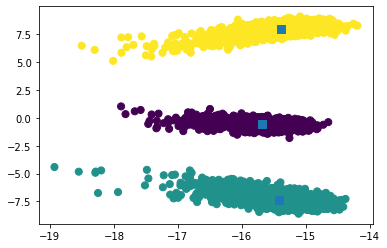

In [94]:
user_preference = pd.read_csv("../data_files/user_history.csv")
user_ratings = pd.read_csv("../data_files/user_ratings.csv")
data = user_preference.drop('USER ID', axis=1).values

# Plotting the objective value for clustering on fancy data with different values for k
from sklearn.cluster import KMeans
# print(data)
# objective = []
# for k in range(1,11):
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(user_preference)
#     objective.append(kmeans.inertia_)
# plt.plot([i for i in range(1,11)],objective)

# Performing KMeans on preference_data
kmeans = KMeans(n_clusters=3)
kmeans.fit(data)
y_kmeans = kmeans.predict(data)

# Using first two principal components to make scatter plot of centroids and clusters
U, S, VT = np.linalg.svd(data.T)
# print(S)

fancy_data_pcbasis = U.T @ data.T
clusters_pcbasis = U.T @ kmeans.cluster_centers_.T

plt.scatter(fancy_data_pcbasis[0], fancy_data_pcbasis[1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(clusters_pcbasis[0], clusters_pcbasis[1], s=80, marker='s')

In [95]:
# THIS IS WHERE YOU PICK WHICH GROUP TO TRAIN ON
# CHANGE THE y_kmeans==[0,1,2] to select a group
# The group whose first USER ID is 100965 is the one that works

group = user_preference.iloc[y_kmeans==0]
# group
# y_kmeans
# kmeans.predict(group.drop('USER ID', axis=1))
# user_ratings

In [96]:
# Doing PCA
data = group.drop('USER ID', axis=1).values
U, S, VT = np.linalg.svd(data.T)
group_pca = U.T @ data.T

In [97]:
# Adding columns to group data
group['pca_1'] = group_pca[0]
group['pca_2'] = group_pca[1]
group['pca_3'] = group_pca[2]
group['pca_4'] = group_pca[3]
group['pca_5'] = group_pca[4]
group['pca_6'] = group_pca[5]
group['pca_7'] = group_pca[6]
group['pca_8'] = group_pca[7]
group['pca_9'] = group_pca[8]
group['pca_10'] = group_pca[9]

/Users/jordanprudhomme/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/jordanprudhomme/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jordanprudhomme/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [98]:
# This is to remove all the 100 website data features
group_reduced = group[['USER ID', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10']].set_index('USER ID')

In [99]:
# Isolating the ratings that correspond with group in the user_ratings and then adding in the user pca to each rating
data = pd.read_csv("../data_files/user_ratings.csv", index_col='USER ID')
ratings = data.loc[group_reduced.index].dropna()

full = group_reduced.loc[ratings.index]

all_data = pd.concat([ratings,full], axis=1)
all_data.loc[all_data['PRODUCT'] == 'spray karma']
all_data

/Users/jordanprudhomme/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


In [102]:
# One hotting product names
dummies = pd.get_dummies(all_data['PRODUCT']) 
all_data = pd.concat([all_data,dummies], axis=1)
# np.mean(all_data.loc[all_data['PRODUCT'] == 'spray karma']['RATING'])

5.080234833659492

In [103]:
# Separate into training and test data
from sklearn.model_selection import train_test_split

train, test = train_test_split(all_data, test_size=0.30)
x_train = train.drop(['RATING','PRODUCT'], axis=1)
y_train = train['RATING']
x_test = test.drop(['RATING','PRODUCT'], axis=1)
y_test = test['RATING']

In [104]:
# Normalize
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [105]:
# Set up needed parameters and activation for NN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import optimizers

batch_size = 25
epochs=5

def custom_activation(x):
    return (K.sigmoid(x) * 10)

In [106]:
# Make, compile, and train model
model = Sequential()
model.add(Dense(150, activation='sigmoid',
                 input_shape=(110,)))
model.add(Dense(1, activation=custom_activation))
model.compile(
              loss='mean_absolute_error',
                optimizer='adam')
#                 optimizer = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))

model.summary()
model.fit(x_train, y_train.values, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test.values))
model.evaluate(x_test, y_test.values)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 150)               16650     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 151       
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_________________________________________________________________
Train on 35312 samples, validate on 15135 samples
Epoch 1/5
35312/35312 [==============================] - 8s 225us/sample - loss: 2.3303 - val_loss: 2.3332
Epoch 2/5
35312/35312 [==============================] - 6s 169us/sample - loss: 2.3165 - val_loss: 2.3274
Epoch 3/5
35312/35312 [==============================] - 6s 158us/sample - loss: 2.3087 - val_loss: 2.3138
Epoch 4/5
35312/35312 [==============================] - 6s 157us/sample - loss: 2.2995 - val_loss: 2.3071
Epoch 5/5
15135/15135 [==========

2.3081200491448697

# Making Predictions

In [110]:
# group['USER ID'].values
# group_reduced

In [108]:
# Make dataframe of all users in group and products
products = user_ratings['PRODUCT'].unique()
users = group['USER ID'].values
matches = []
for user in users:
    for product in products:
        matches.append([user, product])
matches

final_data = pd.DataFrame(matches, columns=['USER ID', 'PRODUCT'])

In [25]:
# Add in user features
users = group_reduced.loc[final_data['USER ID']].reset_index(drop=True)
all_final_data = pd.concat([final_data,users], axis=1)
all_final_data

,USER ID,PRODUCT,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10
0,100965,spray karma,-17.383017,0.397871,1.615562,-0.718274,0.048066,0.015099,-0.156534,-0.079029,-0.381737,-0.122074
1,100965,nurse october,-17.383017,0.397871,1.615562,-0.718274,0.048066,0.015099,-0.156534,-0.079029,-0.381737,-0.122074
2,100965,balance hostel,-17.383017,0.397871,1.615562,-0.718274,0.048066,0.015099,-0.156534,-0.079029,-0.381737,-0.122074
3,100965,volume pasta,-17.383017,0.397871,1.615562,-0.718274,0.048066,0.015099,-0.156534,-0.079029,-0.381737,-0.122074
4,100965,diana chariot,-17.383017,0.397871,1.615562,-0.718274,0.048066,0.015099,-0.156534,-0.079029,-0.381737,-0.122074
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,125969,tarzan juliet,-17.324668,-0.154056,0.857482,-0.940249,0.001756,-0.139441,0.028347,0.186102,0.487981,0.337484
149996,125969,provide flex,-17.324668,-0.154056,0.857482,-0.940249,0.001756,-0.139441,0.028347,0.186102,0.487981,0.337484
149997,125969,update vibrate,-17.324668,-0.154056,0.857482,-0.940249,0.001756,-0.139441,0.028347,0.186102,0.487981,0.337484
149998,125969,neptune before,-17.324668,-0.154056,0.857482,-0.940249,0.001756,-0.139441,0.028347,0.186102,0.487981,0.337484


In [26]:
# Make predictions
predicting = all_final_data.drop(['USER ID'], axis=1)
dummies = pd.get_dummies(predicting['PRODUCT']) 
predicting = pd.concat([predicting,dummies], axis=1).drop(['PRODUCT'], axis=1)

raw_vals = scaler.fit_transform(predicting) 
pred = model.predict(raw_vals)

In [27]:
all_final_data['RATING'] = pred
all_final_data

,USER ID,PRODUCT,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,RATING
0,100965,spray karma,-17.383017,0.397871,1.615562,-0.718274,0.048066,0.015099,-0.156534,-0.079029,-0.381737,-0.122074,-0.0
1,100965,nurse october,-17.383017,0.397871,1.615562,-0.718274,0.048066,0.015099,-0.156534,-0.079029,-0.381737,-0.122074,-0.0
2,100965,balance hostel,-17.383017,0.397871,1.615562,-0.718274,0.048066,0.015099,-0.156534,-0.079029,-0.381737,-0.122074,-0.0
3,100965,volume pasta,-17.383017,0.397871,1.615562,-0.718274,0.048066,0.015099,-0.156534,-0.079029,-0.381737,-0.122074,-0.0
4,100965,diana chariot,-17.383017,0.397871,1.615562,-0.718274,0.048066,0.015099,-0.156534,-0.079029,-0.381737,-0.122074,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,125969,tarzan juliet,-17.324668,-0.154056,0.857482,-0.940249,0.001756,-0.139441,0.028347,0.186102,0.487981,0.337484,-0.0
149996,125969,provide flex,-17.324668,-0.154056,0.857482,-0.940249,0.001756,-0.139441,0.028347,0.186102,0.487981,0.337484,-0.0
149997,125969,update vibrate,-17.324668,-0.154056,0.857482,-0.940249,0.001756,-0.139441,0.028347,0.186102,0.487981,0.337484,-0.0
149998,125969,neptune before,-17.324668,-0.154056,0.857482,-0.940249,0.001756,-0.139441,0.028347,0.186102,0.487981,0.337484,-0.0


In [ ]:
results = all_final_data[['USER ID', 'PRODUCT', 'RATING']]
results


In [ ]:
results.to_csv('results.csv',index=False)

In [ ]:
# EVERYTHING BELOW IS FROM DEBBUGING AND TESTING

In [28]:
user_ratings.loc[(user_ratings['USER ID'] == 100976)]

,USER ID,PRODUCT,RATING
202,100976,spray karma,2
203,100976,nurse october,4
204,100976,sushi import,4
205,100976,stella micro,7
206,100976,volume pasta,9
207,100976,siren junior,5
208,100976,sheriff java,0
209,100976,harbor moral,2
210,100976,vampire teacher,0
211,100976,bundle forget,0


In [21]:
x = pd.concat([group_1_reduced.iloc[0]]*100, axis=1,ignore_index=True)
x = x.transpose()
y = pd.concat([x,all_dummies], axis=1)
print(x.shape)
print(all_dummies.shape)
y
y_data = scaler.fit_transform(y) 
model_1.predict(y_data)

NameError: name 'group_1_reduced' is not defined

In [109]:
import numpy as np
from sklearn import linear_model

ridge_model = linear_model.RidgeCV()
ridge_model.fit(x_train, y_train)

np.mean((ridge_model.predict(x_test) - y_test)**2)

7.577487766366036